Let's see if we can create a model to predict if a coin will
1. go up by 1%
2. trade in the same zone
3. go down by 1%
in the next 2 hours (12 5m candles)

on CDC exchange, fees are 0.4% per transaction, so we should aim to make at least 0.2% profit on each trade

In [1]:
import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
import seaborn as sns

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import KFold
# from sklearn.utils import class_weight, shuffle
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
# from sklearn.pipeline import Pipeline
from ta.momentum import rsi
from ta.trend import sma_indicator
# from xgboost import XGBClassifier


from cdc_wrapper import CDC

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_percentage_error

from sktime.forecasting.compose import make_reduction, ForecastingPipeline, TransformedTargetForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import ExpandingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

In [2]:
with open('keys.json', 'r') as f:
    keys = json.load(f)

cdc = CDC(keys, sandbox=False)

In [23]:
btc_data = cdc.get_candlesticks('BTC_USDT', '5m', depth=1000)
# btc_data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)
# btc_data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)
# btc_data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)
# btc_data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(btc_data)

df['dt'] = pd.to_datetime(df['t'], unit='ms').dt.to_period('T')
df = df.set_index('dt')

df['o'] = df['o'].astype('float')
df['h'] = df['h'].astype('float')
df['l'] = df['l'].astype('float')
df['c'] = df['c'].astype('float')
df['v'] = df['v'].astype('float')


df = df.drop(columns=['t'])

df

,o,h,l,c,v
dt,,,,,
2023-03-27 14:35,27331.71,27386.03,27289.62,27357.19,8.80952
2023-03-27 14:40,27370.22,27420.61,27340.55,27397.23,8.27725
2023-03-27 14:45,27397.23,27421.30,27368.64,27380.24,11.07805
2023-03-27 14:50,27375.02,27377.59,27311.23,27360.44,4.97351
2023-03-27 14:55,27359.60,27388.33,26955.74,26960.85,32.49045
...,...,...,...,...,...
2023-03-28 15:10,26966.52,26966.52,26928.90,26954.70,2.27810
2023-03-28 15:15,26954.71,27000.42,26954.71,26978.62,3.92830
2023-03-28 15:20,26987.56,27007.58,26969.84,26976.68,3.60320


In [39]:
# sktime targets need to be a dataframe and not a series (unlike usual sklearn targets)
y = df
# X = panel_df.drop(columns=['trials'])


test_size = 12
fh = ForecastingHorizon(np.arange(5, 5*(test_size+1), 5))

y_train, y_test = temporal_train_test_split(
    y=y,
    # X=X,
    test_size=test_size)

y_test

,o,h,l,c,v
dt,,,,,
2023-03-28 14:35,26914.05,26952.05,26914.05,26924.30,5.6984
2023-03-28 14:40,26924.52,26965.19,26895.85,26950.34,6.6659
2023-03-28 14:45,26944.96,26989.47,26944.96,26966.54,3.5533
2023-03-28 14:50,26970.82,26985.86,26923.41,26928.12,6.5273
2023-03-28 14:55,26930.88,26960.96,26912.64,26944.79,3.8703
2023-03-28 15:00,26944.04,27003.22,26940.39,26979.02,4.0077
2023-03-28 15:05,26979.02,26990.57,26966.53,26966.53,3.4828
2023-03-28 15:10,26966.52,26966.52,26928.90,26954.70,2.2781
2023-03-28 15:15,26954.71,27000.42,26954.71,26978.62,3.9283


In [40]:
fh

ForecastingHorizon([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], dtype='int64', is_relative=True)

In [41]:
############# SKTIME WORKFLOW


# select your regressor

# we will just use XGBoost but you can use any regressor
regressor = XGBRegressor(random_state=0)

# now we will define our window functions that will be applied to target(s)
# helper class known as a WindowSummarizer will do this for us

# we can also define our own aggregations
def weighted_mean(x):
    weights = np.arange(1,len(x)+1) / np.sum(np.arange(1,len(x)+1))
    return np.sum(weights*x)    

kwargs = {
    'lag_feature': {
        # generate lag features of y, starting with T-1 until T-7 (8 not inclusive)
        # this will generate 7 new columns (we won't see them but they are generated in the pipeline)
        'lag': np.arange(1, 8),
        # generate mean of lags, with lag of 1, and window of last 3 lags
        # this will generate 2 new columns
        'mean': [[1, 6], [1, 12]],
        # generate weighted mean of lags, with lag of 1, and window of last 3 lags
        # this will generate 2 new columns
        weighted_mean: [[1, 6], [1, 12]],
        'std': [[1, 6], [1, 12]],
        'skewness': [[1, 6], [1, 12]],
        'kurtosis': [[1, 6], [1, 12]],
        
    }
}


# we will work backwards to build our pipeline


# make_reduction function converts vertical time series data into horizontal table form
# so we can have T-1, ..., T-n lags predicting T
forecaster = make_reduction(
    estimator=regressor,
    # tranformer here would be our WindowSummarizer which will generate the columns we requested above
    transformers=[WindowSummarizer(**kwargs, n_jobs=1)],
    # window_length supposed to help you create lags, but not needed for now since we manually defined them in our WindowSummarizer
    window_length=None,
    # calculate subsequent windows recursively, i.e. using predictions to form the basis for subsequent predictions
    strategy='recursive',
    # global pooling i.e. to use the whole dataset (multiple time series since multiple countries) rather than individual time series
    pooling='global'
)

# xgboost not appropriate for extrapolating into the future 
# so we need to ensure we decompose trend and seasonality so we can put them back later
# and only use xgboost to train on the residuals

# we can set some default parameters for now (e.g. whether additive or multiplicative, etc.) and let the grid/random search sort it out later

# this TransformedTargetForecaster are to transform y

forecaster = TransformedTargetForecaster(
    steps=[
        ('deseasonalizer', Deseasonalizer(model='multiplicative', sp=180)),
        ('detrender', Detrender(forecaster=PolynomialTrendForecaster(degree=1,), model='multiplicative')),
        ('forecaster', forecaster)
    ]
)

# we may also want to transform X
# in this case, we are generating date time features to act as other features

datetime_feature_transformer = DateTimeFeatures(manual_selection=['day_of_year','day_of_month','day_of_week','day_of_week','month_of_year','quarter_of_year'])

# ForecastingPipeline only for applying transformer to X
forecaster_pipeline = ForecastingPipeline(
    steps=[
        ('daily_season', datetime_feature_transformer),
        ('forecaster', forecaster)
    ]
)

####### OUR SKTIME PIPELINE IS COMPLETE
####### NOW WE NEED TO PUT IT INTO A CROSS VALIDATION PIPELINE

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


In [42]:
###################### BUILDING CV PIPELINE

# creating a lame param grid for now, since this is just an illustration

param_grid = {
    'forecaster__forecaster__estimator__n_estimators':[100, 500, 1000],
    'forecaster__forecaster__estimator__learning_rate':[0.05, 0.3],
    'forecaster__forecaster__estimator__gamma':[1],
    'forecaster__forecaster__estimator__max_depth':[6],
    'forecaster__forecaster__estimator__subsample':[1],
    'forecaster__forecaster__estimator__alpha':[1],
    'forecaster__detrender__forecaster__degree':[1, 2],
    'forecaster__detrender__model':['additive'],
    'forecaster__deseasonalizer__model':['multiplicative'],
    # 'forecaster__deseasonalizer__sp':[12, 24, 36, 48, 60, 72],
    'forecaster__deseasonalizer__sp':[12, 24, 36],
    'daily_season__manual_selection': [
        ['day_of_year','day_of_month','day_of_week','day_of_week','month_of_year','quarter_of_year'],
        # ['day_of_year','day_of_month','day_of_week'],
    ]

}

# we can use either a SlidingWindowSplitter or ExpandingWindowSplitter
# for this illustration we'll use Expanding
cv = ExpandingWindowSplitter(fh=fh, initial_window=144, step_length=test_size)


# note how we are using a forecasting grid/randomized search and not the default one from sktime
# here we use grid search but feel free to use randomized search if you want
gscv = ForecastingGridSearchCV(
    forecaster = forecaster_pipeline,
    cv=cv,
    param_grid=param_grid,
    n_jobs=-1
)

# fit and let it do the grid search
gscv.fit(y_train)


# generate predictions based on forecasting horizon
y_preds = gscv.predict(fh=fh)

c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
c:\Users\cetyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sktime\transformations\series\date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_origin

In [43]:
print(gscv.best_params_)
print(mean_absolute_percentage_error(y_test,y_preds))

{'daily_season__manual_selection': ['day_of_year', 'day_of_month', 'day_of_week', 'day_of_week', 'month_of_year', 'quarter_of_year'], 'forecaster__deseasonalizer__model': 'multiplicative', 'forecaster__deseasonalizer__sp': 12, 'forecaster__detrender__forecaster__degree': 1, 'forecaster__detrender__model': 'additive', 'forecaster__forecaster__estimator__alpha': 1, 'forecaster__forecaster__estimator__gamma': 1, 'forecaster__forecaster__estimator__learning_rate': 0.3, 'forecaster__forecaster__estimator__max_depth': 6, 'forecaster__forecaster__estimator__n_estimators': 500, 'forecaster__forecaster__estimator__subsample': 1}
0.19278123460739258


In [44]:
y_test

,o,h,l,c,v
dt,,,,,
2023-03-28 14:35,26914.05,26952.05,26914.05,26924.30,5.6984
2023-03-28 14:40,26924.52,26965.19,26895.85,26950.34,6.6659
2023-03-28 14:45,26944.96,26989.47,26944.96,26966.54,3.5533
2023-03-28 14:50,26970.82,26985.86,26923.41,26928.12,6.5273
2023-03-28 14:55,26930.88,26960.96,26912.64,26944.79,3.8703
2023-03-28 15:00,26944.04,27003.22,26940.39,26979.02,4.0077
2023-03-28 15:05,26979.02,26990.57,26966.53,26966.53,3.4828
2023-03-28 15:10,26966.52,26966.52,26928.90,26954.70,2.2781
2023-03-28 15:15,26954.71,27000.42,26954.71,26978.62,3.9283


In [45]:
y_preds

,o,h,l,c,v
dt,,,,,
2023-03-28 14:35,26886.211599,26937.453769,26858.046342,26961.905321,7.041211
2023-03-28 14:40,26844.430465,26909.630890,26846.890955,26877.507375,8.578154
2023-03-28 14:45,26877.439495,26908.315816,26847.019981,26884.866067,5.608009
2023-03-28 14:50,26904.954622,26874.220438,26867.726824,26985.449083,7.619858
2023-03-28 14:55,26870.082594,26876.419322,26873.887780,27029.626464,6.098718
2023-03-28 15:00,26865.073839,26890.054747,26870.398124,27018.378020,3.792135
2023-03-28 15:05,26925.859183,26878.542345,26862.896483,26959.687385,2.323930
2023-03-28 15:10,26919.853407,26874.831732,26860.638664,26935.794642,13.234711
2023-03-28 15:15,26884.429610,26880.375021,26863.485885,26841.929402,4.410627


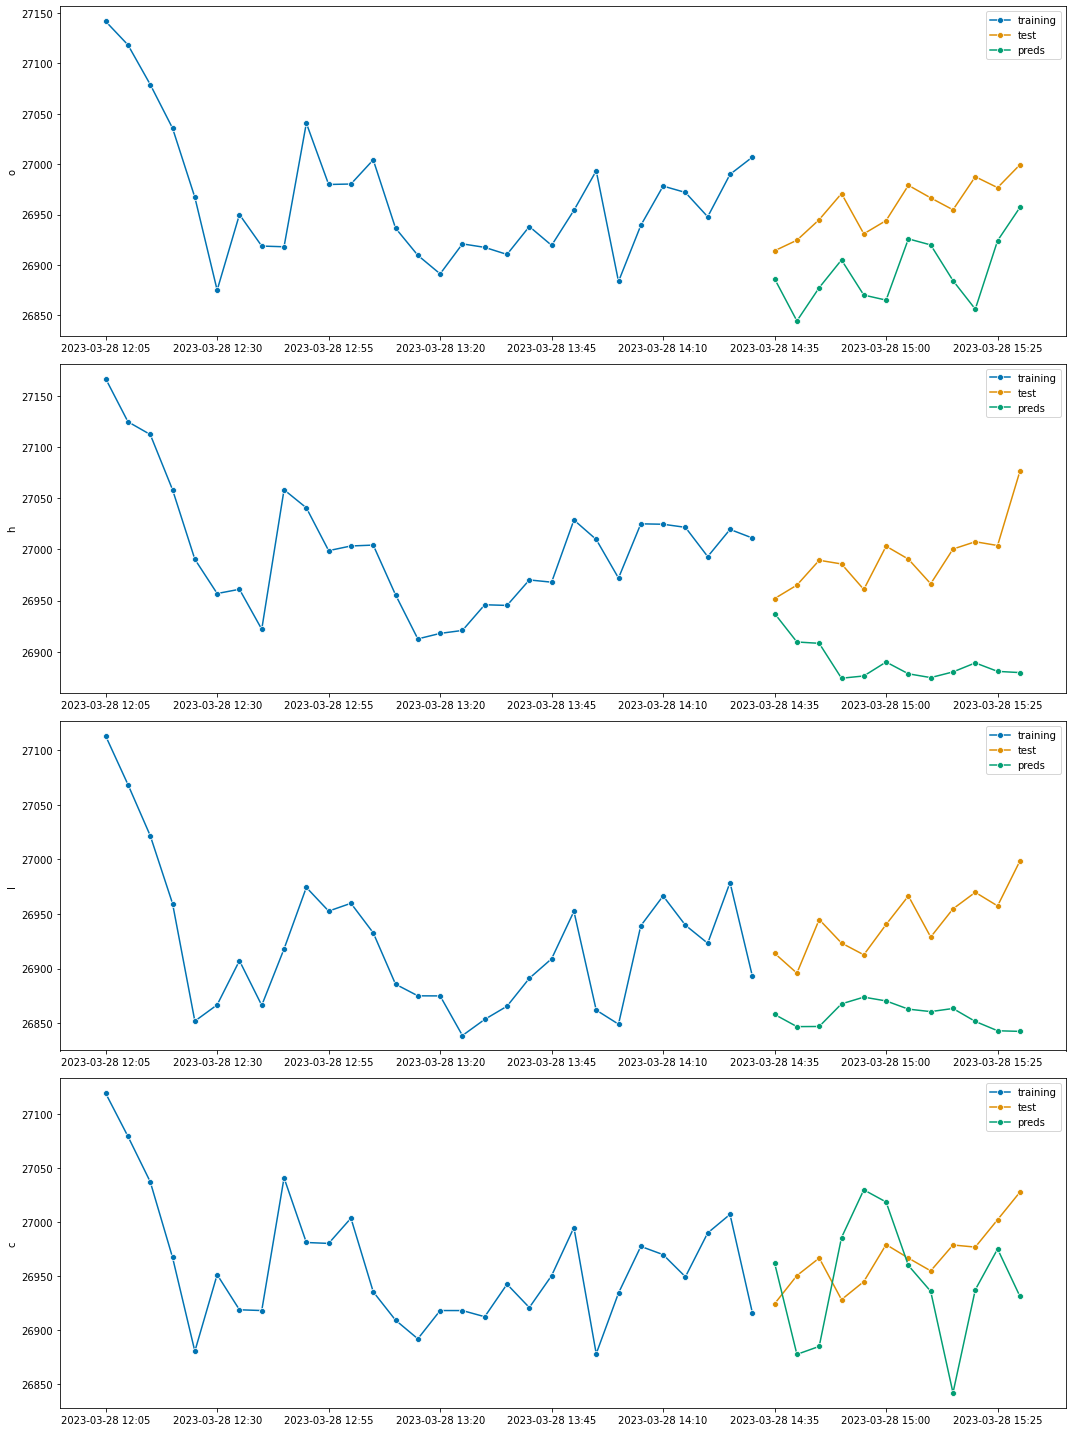

In [51]:

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 20))
counter=0

for i in ['o', 'h', 'l', 'c']:

    plot_series(
        y_train[i].iloc[-30:],
        y_test[i],
        y_preds[i],
        labels=[
            'training',
            'test',
            'preds'
        ],
        ax=axes[counter]
    )

    counter += 1

plt.tight_layout()
plt.show()


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='c'>)

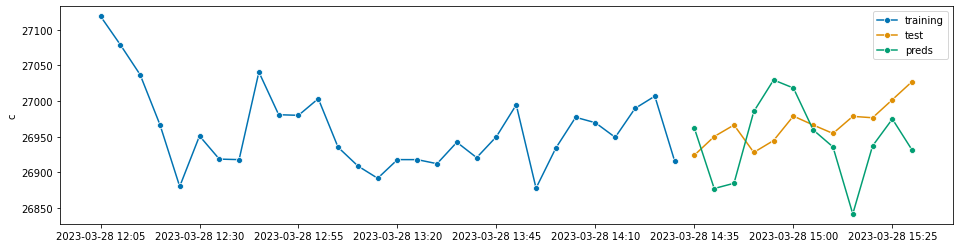

In [48]:
plot_series(
    y_train['c'].iloc[-30:],
    y_test['c'],
    y_preds['c'],
    labels=[
        'training',
        'test',
        'preds'
    ]
)

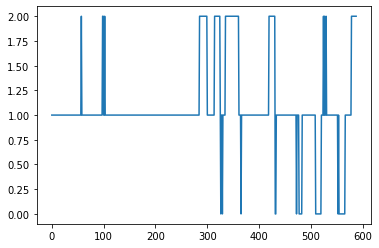

In [44]:
data = cdc.get_candlesticks('BTC_USDC', '5m', depth=1000)

df = pd.DataFrame.from_records(data)

future_window = 12
future_diff_threshold = 0.012

# convert our unix timestamp to dt
df['dt'] = pd.to_datetime(df['t'], unit='ms')

# calculate future values so we can set our labels
# will do feature engineering after this

future_cols = []
for i in range(1, future_window+1):
    df[f'h_{i}'] = df['h'].shift(-i)
    df[f'l_{i}'] = df['l'].shift(-i)
    future_cols.append(f'h_{i}')
    future_cols.append(f'l_{i}')

# drop the rows that will not have the full future values
df = df.iloc[:-future_window]

df['future_min'] = df.apply(lambda x: x[future_cols].min(), axis=1)
df['future_max'] = df.apply(lambda x: x[future_cols].max(), axis=1)

# can't think of how to decide if future_min came first or future_max came first
# so in the event that BOTH are more than 1% apart, will label as a "no difference"

df['min_flag'] = ((df['c'] - df['future_min']) / df['c']) > future_diff_threshold
df['max_flag'] = ((df['future_max'] - df['c']) / df['c']) > future_diff_threshold

df['label'] = 1
df.loc[(df['min_flag']==True)&(df['max_flag']==False), 'label'] = 0
df.loc[(df['min_flag']==False)&(df['max_flag']==True), 'label'] = 2
df.loc[(df['min_flag']==True)&(df['max_flag']==True), 'label'] = 1

df = df[['c', 'label']]

y = df['label'].values

plt.plot(y)

bot i want to build

1. websocket will eventually just keep streaming any number of pairs (for example, now it's just BTC_USDC, ETH_USDC, ETH_BTC, but should be able to just include any)
2. save the streamed data (into let's say CSVs, or maybe even GCP bucket?) but also the bot will be able to take in gaps in the training data (e.g. websocket is closed for 1 week for some reason)
3. should be able to create a bot for various pairs based on the data saved above
4. each bot can take in various parameters to decide indicators, window sizes, etc
5. maybe eventually try to automate (i.e. bot will loop through various parameters to find the one that can produce the best model and by extension strategy)


But anyway for the model building

1. Read in data
2. Initial preprocessing - all up until labelling
3. Train test split?
4. Pipeline
- feature engineering and scaling etc
 

In [4]:
def initial_preprocessing(df, future_window, future_diff_threshold, allow_overlap=False, random_state=None):
    """Takes in a df with columns [instrument, t, o, h, l, c, v] and returns it with labels based on future numbers.
    Label can be [0, 1, 2] where 1 means that within future_window time points in the future, the price went below (latest closing price * (1-future_diff_threshold)).
    2 means that within future_window time points in the future, the price went above (latest closing price * (1+future_diff_threshold))
    0 means neither of the above (latest closing price stayed within +- future_diff threshold)

    If there are gaps between data, such as (assuming 5 min candles) one row ending at 00:05am and the next one starting at 00:15am (and not 00:10am), future windows will not be calculated across the gap.
    That also means that chunks of data smaller than future_window will probably be discarded
    Gaps determined based on MIN of distance between rows. e.g. if the smallest interval is 5 mins, then 5 mins will be the stardard, anything else will be the gap 

    If allow_overlap is False, will drop rows that overlap each other.
    For instance, (assuming 5 min candles) a row that starts from 00:00am with 5 future windows (25 mins into the future) will overlap with a row that starts from 00:15am

    random_state will allow seeding of numpy random generator (is reset before the function returns)
    """

    # drop duplicates because the websocket just gets data every 30s, a lot of repeated data
    df = df.drop_duplicates()

    #  multiple instruments in there, so group by
    # also because of repeated data inflow, only want the last time for each instrument/time combi
    df = df.groupby(['instrument', 't']).last().reset_index()
    df['dt'] = pd.to_datetime(df['t'], unit='ms')

    # separate df into different instruments
    dfs = []
    for instrument in df['instrument'].unique():
        dfs.append(df.loc[df['instrument']==instrument].copy())

    # instrument level
    final_dfs = []
    for sub_df in dfs:

        sub_df = sub_df.sort_values('dt')
        sub_df['dt_diff'] = sub_df['dt'].diff()
        dt_diff_min = sub_df['dt_diff'].min()
        sub_df['dt_diff_check'] = sub_df['dt_diff'] == dt_diff_min
        sub_df = sub_df.reset_index()

        # get indexes where dt_diff_check is False
        # it's the start of a new sub_df (after the gap)
        new_sub_df_indexes = sub_df.loc[~sub_df['dt_diff_check']].index.tolist()
        sub_sub_dfs = []
        for i, index in enumerate(new_sub_df_indexes):
            # if there's only one value, then the whole thing is the sub sub df
            if len(new_sub_df_indexes) == 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # whereas if it's the last value, then it's that til the end
            elif i == len(new_sub_df_indexes) - 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_dfs.append(sub_sub_df.copy())
            # otherwise, stop before next value in list
            else:
                sub_sub_df = sub_df.iloc[index:new_sub_df_indexes[i+1]]
                sub_sub_dfs.append(sub_sub_df.copy())

        # for sub_sub_df in sub_sub_dfs:
        #     print(sub_sub_df.head())

        

        for sub_sub_df in sub_sub_dfs:
            
            # simply throw out sub_sub_dfs that cannot even get the future window
            if len(sub_sub_df) > future_window:

                sub_sub_df['future_max'] = sub_sub_df['h'].iloc[::-1].rolling(future_window+1).max().iloc[::-1]
                sub_sub_df['future_min'] = sub_sub_df['l'].iloc[::-1].rolling(future_window+1).min().iloc[::-1]
                sub_sub_df = sub_sub_df.loc[~sub_sub_df['future_max'].isna()].copy()
                sub_sub_df['min_flag'] = ((sub_sub_df['c'] - sub_sub_df['future_min']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['max_flag'] = ((sub_sub_df['future_max'] - sub_sub_df['c']) / sub_sub_df['c']) > future_diff_threshold
                sub_sub_df['label'] = 0
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==False), 'label'] = 1
                sub_sub_df.loc[(sub_sub_df['min_flag']==False)&(sub_sub_df['max_flag']==True), 'label'] = 2
                sub_sub_df.loc[(sub_sub_df['min_flag']==True)&(sub_sub_df['max_flag']==True), 'label'] = 0
                sub_sub_df['label_bin'] = 0
                sub_sub_df.loc[sub_sub_df['label']==2, 'label_bin'] = 1
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label', 'label_bin']]
                # only append if len sub sub df > future window
                final_dfs.append(sub_sub_df)

    df = pd.concat(final_dfs, axis=0)
    return df

def basic_feature_engineering(df, past_window, remove_overlap=True, random_state=None):
    """Takes in a initially preprocessed df (run through the initial_preprocessing function) and
    does basic feature engineering of adding past windows, as well as removing overlap
    """
    np.random.seed(random_state)
    random_choice = np.random.choice(past_window)
    print('random choice:', random_choice)

    # firstly, break out into instruments again

    sub_dfs = []
    for instrument in df['instrument'].unique():
        sub_dfs.append(df.loc[df['instrument']==instrument].copy())

    final_dfs = []

    for sub_df in sub_dfs:

        sub_df = sub_df.sort_values('dt')
        sub_df['dt_diff'] = sub_df['dt'].diff()
        dt_diff_min = sub_df['dt_diff'].min()
        sub_df['dt_diff_check'] = sub_df['dt_diff'] == dt_diff_min
        sub_df = sub_df.reset_index()

        # get indexes where dt_diff_check is False
        # it's the start of a new sub_df (after the gap)
        new_sub_df_indexes = sub_df.loc[~sub_df['dt_diff_check']].index.tolist()
        sub_sub_dfs = []
        for i, index in enumerate(new_sub_df_indexes):
            # if there's only one value, then the whole thing is the sub sub df
            if len(new_sub_df_indexes) == 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label', 'label_bin']]
                sub_sub_dfs.append(sub_sub_df.copy())
            # whereas if it's the last value, then it's that til the end
            elif i == len(new_sub_df_indexes) - 1:
                sub_sub_df = sub_df.iloc[index:]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label', 'label_bin']]
                sub_sub_dfs.append(sub_sub_df.copy())
            # otherwise, stop before next value in list
            else:
                sub_sub_df = sub_df.iloc[index:new_sub_df_indexes[i+1]]
                sub_sub_df = sub_sub_df[['instrument', 'dt', 'o', 'h', 'l', 'c', 'v', 'label', 'label_bin']]
                sub_sub_dfs.append(sub_sub_df.copy())



        for sub_sub_df in sub_sub_dfs:
            if len(sub_sub_df) >= past_window:
                frames = [sub_sub_df]
                for i in range(1, past_window):
                    temp = pd.DataFrame()
                    temp[f'o_{i}'] = sub_sub_df['o'].shift(i).copy()
                    temp[f'h_{i}'] = sub_sub_df['h'].shift(i).copy()
                    temp[f'l_{i}'] = sub_sub_df['l'].shift(i).copy()
                    temp[f'c_{i}'] = sub_sub_df['c'].shift(i).copy()
                    temp[f'v_{i}'] = sub_sub_df['v'].shift(i).copy()
                    frames.append(temp)

                sub_sub_df = pd.concat(frames, axis=1)
                sub_sub_df = sub_sub_df.loc[~sub_sub_df[f'o_{past_window-1}'].isna()]
                sub_sub_df['temp_index'] = sub_sub_df.index + 1
                sub_sub_df['temp_index_2'] = sub_sub_df['temp_index'] % random_choice
                sub_sub_df = sub_sub_df.loc[sub_sub_df['temp_index_2']==0].copy()
                sub_sub_df = sub_sub_df.drop(columns=['temp_index', 'temp_index_2'])
                final_dfs.append(sub_sub_df)

    df = pd.concat(final_dfs, axis=0)
    np.random.seed()
    return df    

In [18]:
data_file_name = 'data3.csv'
instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

data_filenames = [filename for filename in os.listdir() if filename.startswith('data') and filename.endswith('.csv')]

dfs = []

for filename in data_filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

df = pd.concat(dfs)

df = initial_preprocessing(df, future_window=future_window, future_diff_threshold=future_diff_threshold, random_state=1)

df = basic_feature_engineering(df, past_window=24, random_state=1)

df


random choice: 5


,instrument,dt,o,h,l,c,v,label,label_bin,o_1,...,o_22,h_22,l_22,c_22,v_22,o_23,h_23,l_23,c_23,v_23
24,BTC_USDC,2022-07-08 11:50:00,21630.63,21638.96,21594.25,21604.20,0.457086,1,0,21599.86,...,21557.01,21587.16,21541.21,21563.42,2.690903,21493.98,21578.70,21485.45,21555.08,5.224304
29,BTC_USDC,2022-07-08 12:15:00,21630.71,21700.68,21630.71,21644.68,2.202582,1,0,21592.83,...,21679.73,21720.29,21660.15,21676.94,4.292558,21602.81,21683.32,21591.01,21679.73,1.976149
34,BTC_USDC,2022-07-08 12:40:00,21444.22,21453.82,21322.92,21322.92,2.285154,0,0,21440.43,...,21604.52,21604.57,21532.50,21565.23,0.500846,21630.60,21630.60,21569.79,21603.38,0.819615
39,BTC_USDC,2022-07-08 13:05:00,21401.38,21411.77,21339.96,21377.08,2.697587,0,0,21357.32,...,21507.84,21530.32,21475.02,21517.15,1.579408,21484.92,21506.92,21454.68,21503.91,1.146705
44,BTC_USDC,2022-07-08 13:30:00,21363.08,21379.71,21255.83,21324.77,4.836931,0,0,21366.21,...,21625.52,21627.70,21581.20,21598.85,0.914025,21653.29,21653.29,21595.69,21627.38,0.484637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9654,ETH_USDC,2022-08-12 13:55:00,1881.46,1885.38,1878.60,1884.61,16.953840,0,0,1880.48,...,1868.87,1877.99,1867.50,1877.30,10.288170,1869.74,1871.17,1868.11,1869.66,8.739480
9659,ETH_USDC,2022-08-12 14:20:00,1887.25,1889.45,1884.32,1886.57,21.165120,0,0,1882.73,...,1878.56,1881.87,1878.56,1880.65,5.286970,1880.44,1882.11,1878.28,1878.34,10.235980
9664,ETH_USDC,2022-08-12 14:45:00,1882.02,1882.86,1876.81,1878.68,6.850310,2,1,1883.02,...,1881.89,1882.11,1879.71,1881.10,5.012080,1882.17,1883.19,1880.99,1881.11,2.048040
9669,ETH_USDC,2022-08-12 15:10:00,1879.57,1884.62,1879.36,1884.08,10.091070,2,1,1883.79,...,1881.56,1882.39,1880.08,1880.63,2.204770,1883.56,1885.62,1880.67,1880.67,5.609830


Low sample size, let's do k fold cross validation

In [7]:
# data_file_name = 'data3.csv'
# instrument = 'ETH_USDC'
future_window = 12
future_diff_threshold = 0.012
past_window = 24 # 2 hours?

data_filenames = [filename for filename in os.listdir() if filename.startswith('data') and filename.endswith('.csv')]

dfs = []

for filename in data_filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

df = pd.concat(dfs)

df = initial_preprocessing(df, future_window=future_window, future_diff_threshold=future_diff_threshold, random_state=1)

df = basic_feature_engineering(df, past_window=past_window, random_state=1)

# let's just do BTC USDC for now
label = 'label_bin'
random_state = 1

btc_df = df.loc[df['instrument']=='BTC_USDC']

# balance the classes first
min_sample = btc_df[label].value_counts().min()

dfs = []
for l in btc_df[label].unique():
    dfs.append(btc_df.loc[btc_df[label]==l].sample(min_sample))

btc_df = pd.concat(dfs)
btc_df = shuffle(btc_df, random_state=random_state)

btc_df = btc_df.rename(columns={
    'o': 'o_0',
    'h': 'h_0',
    'l': 'l_0',
    'c': 'c_0',
    'v': 'v_0'
})

X_cols = [col for col in btc_df.columns if (col.startswith('o_') or col.startswith('h_') or col.startswith('l_') or col.startswith('c_') or col.startswith('v_'))]
y_col = label

X = btc_df[X_cols]
y = btc_df[y_col]

kfolder = KFold(n_splits=3)

# n_estimators = [10, 50, 100, 250, 500, 1000]
# learning_rates = [0.01, 0.025, 0.05, 0.1]

n_estimators = [100]
learning_rates = [0.05, 0.025]

results = []

for n in n_estimators:
    for lr in learning_rates:

        scores = []

        for train_index, test_index in kfolder.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1, 2], y=y_train)
            sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_test)

            # model = XGBClassifier(n_estimators=1000, learning_rate=0.1, early_stopping_rounds=10, scale_pos_weight=class_weights, random_state=random_state)
            model = XGBClassifier(n_estimators=n, learning_rate=lr, early_stopping_rounds=10, random_state=random_state, verbosity=0)
            
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
            predictions = model.predict(X_test)

            # score = balanced_accuracy_score(y_test, predictions, sample_weight=sample_weights)
            score = accuracy_score(y_test, predictions)
            scores.append(score)

            cm = confusion_matrix(y_test, predictions)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title(f'n_estimators: {n}, learning_rate: {lr}, score: {score}')
            plt.show(block=False)

            

        results.append(f'n_estimators: {n}, learning_rate: {lr}, score: {np.mean(scores)}')

for result in results:
    print(result)

random choice: 5


,o_0,h_0,l_0,c_0,v_0,o_1,h_1,l_1,c_1,v_1,...,o_22,h_22,l_22,c_22,v_22,o_23,h_23,l_23,c_23,v_23
3144,23356.74,23356.74,23299.42,23338.40,2.882064,23362.20,23416.56,23342.95,23351.87,3.322647,...,23627.93,23670.18,23607.10,23617.70,4.011423,23727.06,23727.06,23637.02,23646.18,3.358564
3104,23607.93,23664.01,23592.65,23655.81,4.103186,23516.78,23601.69,23516.78,23592.93,4.013867,...,24065.72,24105.50,23991.69,24075.96,5.509474,24137.10,24143.25,24059.25,24065.72,1.946569
2774,22233.13,22266.38,22175.90,22264.24,2.964938,22282.78,22300.99,22218.80,22234.26,2.156428,...,22093.86,22182.17,22071.11,22174.23,1.978143,22119.52,22139.50,22078.38,22100.99,2.442603
4444,22044.75,22056.54,22024.89,22041.13,1.750317,22051.49,22074.15,22040.68,22045.21,1.433253,...,21971.58,21975.37,21957.80,21964.53,0.105699,21970.35,21983.56,21962.80,21972.06,0.890342
1459,20386.57,20416.86,20379.92,20386.55,0.227292,20432.96,20437.17,20379.67,20379.67,1.017312,...,20473.88,20496.39,20473.88,20483.52,0.258467,20474.21,20479.16,20451.36,20471.88,0.532144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5554,23958.20,23978.60,23930.67,23978.60,0.504446,23966.70,23989.82,23949.53,23953.08,0.750695,...,23981.10,23987.52,23945.37,23983.18,0.167212,23916.70,23988.17,23914.27,23982.01,1.262173
9079,23133.66,23137.06,23110.61,23132.64,1.240880,23127.14,23135.19,23109.59,23124.84,0.165165,...,23053.50,23062.72,23036.97,23054.88,0.303807,23053.70,23055.78,23039.33,23053.21,0.113118
9679,24010.22,24024.84,23993.67,24018.87,0.469275,24003.22,24019.74,23994.34,24010.22,0.540583,...,23862.23,23906.58,23861.17,23894.43,1.744919,23827.28,23875.49,23826.64,23865.41,2.496122
3134,23044.41,23104.73,23022.65,23048.61,3.806523,23029.01,23149.10,22990.76,23100.88,4.385140,...,23742.51,23818.30,23734.05,23805.89,0.528455,23789.54,23794.28,23675.41,23740.22,2.674930


In [8]:
a = pd.DataFrame()

a['test'] = np.arange(10)

a

,test
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [89]:
windows = max(rsi_windows + sma_windows)

testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=windows+future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')
results_df = testing_df.copy()[-future_window:]
print(results_df['l'].min(), results_df['h'].max())
testing_df = testing_df[:-future_window]



testing_df = testing_df.set_index('dt')
testing_df = testing_df.drop('t', axis=1)

for w in rsi_windows:
    testing_df[f'rsi{w}'] = rsi(testing_df['c'], window=w)

for w in sma_windows:
    testing_df[f'sma{w}'] = sma_indicator(testing_df['c'], window=w)



X_cols = [col for col in testing_df.columns if col != 'label']
# # let's bring in the past values

dfs = [testing_df]

for i in range(1, past_window+1):

    dataframe = testing_df.copy().shift(i)
    new_cols = [f'{col}_{i}' for col in dataframe.columns]
    dataframe.columns = new_cols
    dfs.append(dataframe)
    # for col in X_cols:
    #     testing_df[f'{col}_{i}'] = testing_df[col].shift(i)

testing_df = pd.concat(dfs, axis=1)

testing_df

# drop rows with NAs i.e. those that maybe be missing some indicators (due to the window) or past data
testing_df = testing_df.dropna()

X = testing_df

X = scaler.transform(X)

X = xgb.DMatrix(X)

bst.predict(X)

19649.37 19900.99


array([0.], dtype=float32)

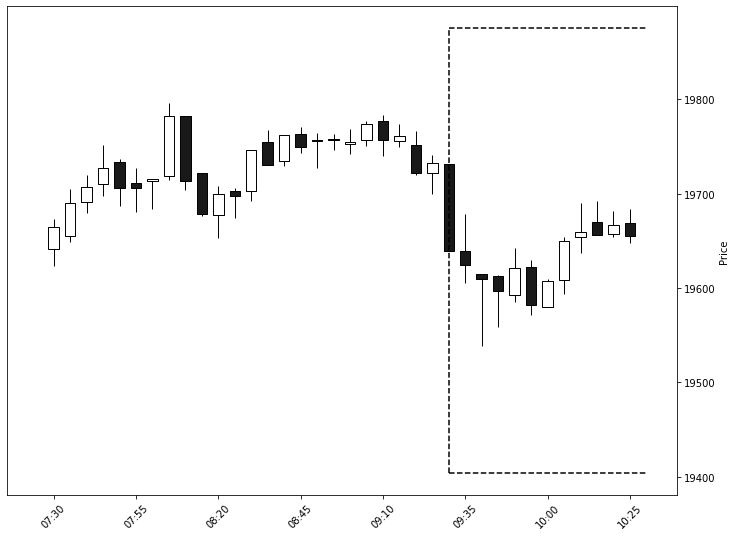

In [77]:
testing_data = cdc.get_candlesticks(instrument_name=instrument, time_frame='5m', depth=future_window+past_window)

testing_df = pd.DataFrame.from_records(testing_data)

testing_df['dt'] = pd.to_datetime(testing_df['t'], unit='ms')

testing_df = testing_df.drop('t', axis=1).set_index('dt').rename({'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(12,9))

mpl.plot(
    testing_df,
    type='candle',
    style='classic',
    ax=ax
)

plt.sca(ax)

vline_y_min = min(testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), testing_df['Low'].min())
vline_y_max = max(testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), testing_df['High'].max())

plt.vlines(x=past_window, ymin=vline_y_min, ymax=vline_y_max, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1+future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')
plt.hlines(y=testing_df.iloc[past_window]['Close']*(1-future_diff_threshold), xmin=past_window, xmax=past_window+future_window, colors='black', linestyles='dashed')

plt.show()